In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import psycopg2 as ppg
import os
import re

In [123]:
with ppg.connect(database='Books_', user=os.getenv('USER'), password=os.getenv("PASSWORD")) as conn:
    query = """select b.id, b.title, (a.firstname, a.lastname) as author, ci.title as category, b.description, b.description_nlp, b.rating, b.votes from books b 
	left join authors a on a.id = b.author
	left join category c on c.id = b.category
	left join category_id ci on ci.id = c.cat_id
	left join publisher p on p.id = b.publisher 
    """
    data = pd.read_sql(query, conn)

In [124]:
data.head()

,id,title,author,category,description,description_nlp,rating,votes
0,2905225,Daddy-Long-Legs,"(Джин,Вебстер)",Проза,Эпистолярный роман Джин Вебстер «Длинноногий п...,эпистолярн рома джин вебстер длинноног папочк ...,3.90,10
1,2961065,Бесобой: роман,"(Кирилл,Кутузов)",Фантастика и фентези,История мрачного борца с демонами — теперь в ф...,истор мрачн борц демон формат художествен рома...,3.88,33
2,2946512,"Ночь, когда мы исчезли","(Николай,Кононов)",Проза,"Война застает врасплох. Заставляет бежать, лом...",войн заста врасплох заставля бежа лома привычн...,3.92,64
3,2944570,Любовь. Мечта. Лидерство,"(Анна,Пермиловская)",Спорт,Верить в себя или верить в судьбу? Реагировать...,вер вер судьб реагирова происходя создава реал...,4.40,15
4,2499495,Леонард Коэн. Биография.,"(ND,ND)",Искусство,"Скорее всего, вы никогда не встретите имя Леон...",скор встрет им леонард коэн предложен слон пло...,5.00,1


In [29]:
data.author = data.author.apply((lambda x: (
    x
    .replace('(', '')
    .replace(')', '')
    .replace(',', ' ')
    .replace('"', '')
)))

In [6]:
data.description = data.description.apply((lambda x: ' '.join(re.findall(r'[а-яёА-ЯЁ]+', x))))

### Разведывательный анализ

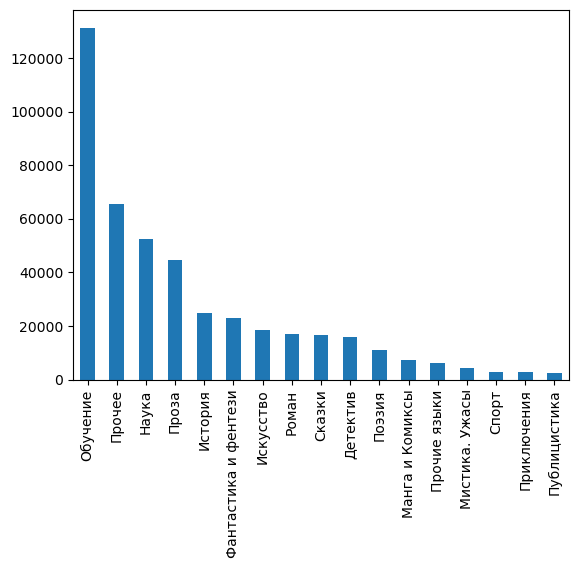

In [7]:
(
    data
    .category
    .value_counts()
    .plot
    .bar()
);

<Axes: ylabel='Frequency'>

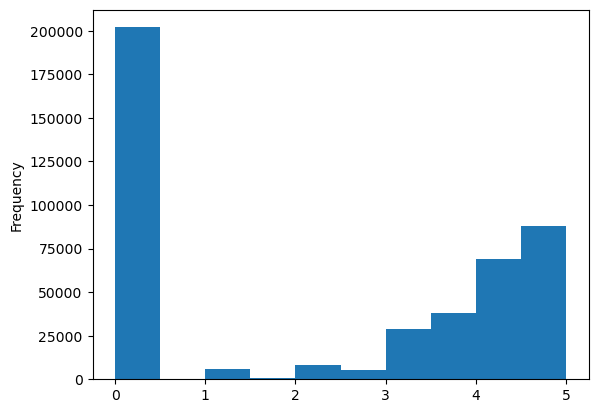

In [8]:
(
    data
    .rating
    .plot
    .hist()
)

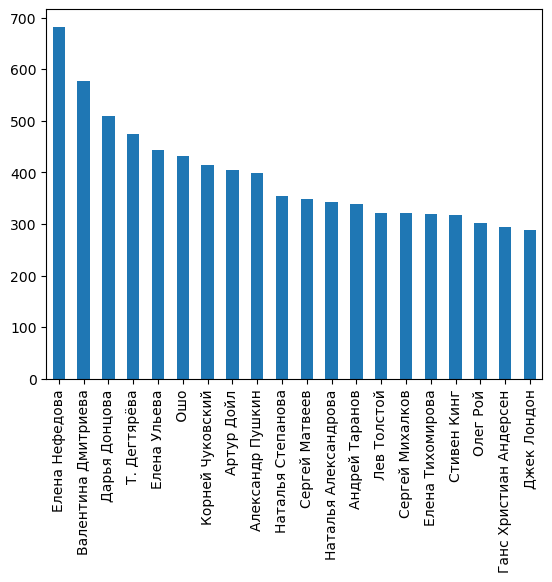

In [9]:
(
    data
    .drop_duplicates(subset='title')
    .author
    .loc[data.author != 'ND ND']
    .value_counts()
    .head(20)
    .plot
    .bar()
);

## Обработка описаний

In [10]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("russian")

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = stopwords.words('english') + stopwords.words('russian')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alexandernazimov/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexandernazimov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandernazimov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
lemm = WordNetLemmatizer()

In [12]:
def tokenize(row):
    token = word_tokenize(row)
    token = [i for i in token if (i not in stop_words)]
    token = [lemm.lemmatize(t) for t in token]
    token = [stemmer.stem(t) for t in token]
    return ' '.join([t.lower() for t in token])

In [152]:
tokenize('Книга про пиратов в карибском море')

'книг пират карибск мор'

In [150]:
# %%time
# data.description = data.description.apply(tokenize)

In [14]:
# data.to_csv('describe.csv')

In [125]:
min_num_ratings = np.min(data.votes)
max_num_ratings = np.max(data.votes)

norm_coef = max_num_ratings - min_num_ratings

In [126]:
data

,id,title,author,category,description,description_nlp,rating,votes
0,2905225,Daddy-Long-Legs,"(Джин,Вебстер)",Проза,Эпистолярный роман Джин Вебстер «Длинноногий п...,эпистолярн рома джин вебстер длинноног папочк ...,3.90,10
1,2961065,Бесобой: роман,"(Кирилл,Кутузов)",Фантастика и фентези,История мрачного борца с демонами — теперь в ф...,истор мрачн борц демон формат художествен рома...,3.88,33
2,2946512,"Ночь, когда мы исчезли","(Николай,Кононов)",Проза,"Война застает врасплох. Заставляет бежать, лом...",войн заста врасплох заставля бежа лома привычн...,3.92,64
3,2944570,Любовь. Мечта. Лидерство,"(Анна,Пермиловская)",Спорт,Верить в себя или верить в судьбу? Реагировать...,вер вер судьб реагирова происходя создава реал...,4.40,15
4,2499495,Леонард Коэн. Биография.,"(ND,ND)",Искусство,"Скорее всего, вы никогда не встретите имя Леон...",скор встрет им леонард коэн предложен слон пло...,5.00,1
...,...,...,...,...,...,...,...,...
445817,2498197,Маркетинговые коммуникации в сфере услуг:специ...,"(Александр,Суглобов)",Обучение,Cпецифика применения и инновационные подходы. ...,пецифик применен инновацион подход монограф от...,0.00,0
445818,2713527,Почему? Книга для чтения .,"(Анатолий,Бердичевский)",Обучение,В книге представлен адаптированный текст повес...,в книг представл адаптирова текст повест б жит...,5.00,1
445819,2941731,Плетеное королевство,"(""Тахира"",Мафи)",Фантастика и фентези,— Мгновенный международный бестселлер по верси...,мгновен международн бестселлер верс тахир маф ...,4.05,88
445820,2920288,Леди и Бродяга. Графический роман,"(Франсуа,Кортеджани)",Манга и Комиксы,Любящая семья и уютная подстилка — реальность ...,любя сем уютн подстилк реальност очаровательн ...,4.50,16


In [127]:
data['coef'] = data.rating * (data.votes - min_num_ratings) / norm_coef

### Добавление обработанных описаний в БД

In [15]:
# for id_, data_ in zip(data.id, data.description):
#     with ppg.connect(database='Books_', user=os.getenv('USER'), password=os.getenv("PASSWORD")) as conn:
#         with conn.cursor() as cur:
#             query = """
#             UPDATE books SET description_nlp = %s WHERE id = %s;
#             """
#             cur.execute(query, (data_, int(id_)))
#             conn.commit()

In [128]:
data = data.set_index('id')

### Векторизация описаний

In [214]:
data.category.unique()

array(['Проза', 'Фантастика и фентези', 'Спорт', 'Искусство', 'Обучение',
       'Наука', 'Манга и Комиксы', 'История', 'Прочее', 'Сказки',
       'Поэзия', 'Приключения', 'Роман', 'Публицистика', 'Детектив',
       'Мистика. Ужасы', 'Прочие языки'], dtype=object)

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [215]:
cat = 'Манга и Комиксы'

In [216]:
to_model = data[data.category==cat]
to_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7222 entries, 2925573 to 2920288
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            7222 non-null   object 
 1   author           7222 non-null   object 
 2   category         7222 non-null   object 
 3   description      7222 non-null   object 
 4   description_nlp  7222 non-null   object 
 5   rating           7222 non-null   float64
 6   votes            7222 non-null   int64  
 7   coef             7222 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 507.8+ KB


In [217]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(to_model.description_nlp)
X_train_tfidf

<7222x27840 sparse matrix of type '<class 'numpy.float64'>'
	with 376035 stored elements in Compressed Sparse Row format>

### Косинусное расстрояние

In [218]:
from sklearn.neighbors import NearestNeighbors

In [219]:
neighbors = NearestNeighbors(n_neighbors=30, metric='cosine') 
neighbors.fit(X_train_tfidf)

NearestNeighbors(metric='cosine', n_neighbors=30)

In [228]:
X_tfidf = tfidf.transform([tokenize('мангака')])

res = neighbors.kneighbors(X_tfidf, return_distance=True)

In [229]:
res

(array([[0.47890649, 0.58479325, 0.60574349, 0.65886932, 0.75663781,
         0.75737664, 0.77653774, 0.79922529, 0.79950189, 0.80197752,
         0.81072254, 0.82362682, 0.82594238, 0.84529217, 0.85104915,
         0.85356064, 0.85866116, 0.8669618 , 0.87163113, 0.87825542,
         0.88193883, 0.88735059, 0.89396717, 0.89515197, 0.90194428,
         0.90489134, 0.90734155, 0.91338593, 0.91727419, 1.        ]]),
 array([[ 768, 3233, 4450, 2073, 6477, 6488, 2393, 3230, 1386, 2908, 3228,
         2614, 6802,   38, 6820, 2829,  413, 3735, 6744, 5780,  381,  767,
          244,  142,  947, 7191, 1928,  948, 2176, 4813]]))

In [230]:
result = to_model.iloc[res[1][0]].sort_values(['coef', 'rating', 'votes'], ascending=[False, False, True])
result = result[['title', 'description', 'rating']]

result.drop_duplicates('title', inplace=True)

In [231]:
result[:10]

,title,description,rating
id,,,
2799141,Призрак в доспехах 1,"Классика киберпанка, всемирно известная манга ...",4.38
2839891,Последнее путешествие девочек. Том 3,Любителям постапокалипсиса с элементами филосо...,4.68
2834178,Последнее путешествие девочек. Том 2,Любителям постапокалипсиса с элементами филосо...,4.60
2934843,Прогулки (ARUKU HITO),"Остановиться на миг в суете бегущих дней, отло...",4.00
2553456,Бакуман. Том 1 . Книги 3-4 : манга,"Мечтая стать лучшими мангаками Японии, Сайко и...",4.86
2620851,Опус,Сатоси Кон известен миру прежде всего как гени...,4.39
2880522,Неопаразит f,У появившихся из ниоткуда инопланетных паразит...,4.02
2643241,Бакуман. Том 5 . Книги 9-10 : манга,В выпуск 5 входят книги 9 и 10.\r\n\r\nКомедий...,4.74
2879430,Assassins Creed: Вальгалла. Кровные братья,Откройте для себя эпическую историю о ярких бр...,3.77
